# 项目简介

来自Kaggle的项目[信用卡欺诈检测](https://www.kaggle.com/mlg-ulb/creditcardfraud)  
数据集包含了2013年9月份其中两天欧洲持卡用户的信用卡交易信息。这是一个很不平衡的数据，284807条交易中仅有492起欺诈交易，占比0.172%。  
由于隐私的关系，数据集中的特征通过PCA进行预处理，得到处理后的V1,V2...V28主成分信息，同时保留了Time特征(距离上一笔交易的时长)。"Amount"为交易金额。"Class"列为响应向量, 1代表欺诈，0代表正常。  

由于数据分类非常不平衡，因此使用混淆矩阵来评估准确率意义不大。项目建议使用AUPRC(Area Under Precision-Recall Curve, 我们习惯称之为AUC)来衡量准确率。

由于数据已经经过PCA预处理，无法进行深入的数据探索。本次主要就模型表现间的差异性来进行分析。  
这里主要考虑使用随机森林与Adaboost算法来做模型训练。

## 1. 数据集metadata

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
rdata = pd.read_csv("data/creditcard.csv")

In [4]:
rdata.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
rdata.shape

(284807, 31)

In [6]:
rdata.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

## 2. 预处理

In [7]:
rdata["Class"] = rdata["Class"].astype("category")
X, y = rdata.iloc[:, 0:30], rdata["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
# 评估Time/Amount列是否需要保留
amount_time = rdata["Amount"]/(rdata["Time"]+1)
amount_time.describe()

count    284807.000000
mean          0.004804
std           0.485099
min           0.000000
25%           0.000063
50%           0.000281
75%           0.001071
max         189.330000
dtype: float64

In [18]:
subdata = rdata.loc[amount_time >= 0.01]

In [22]:
print("Credit Fraud Ratio - Subdata: %.4f" % (sum(subdata["Class"])/len(subdata["Class"]) * 100))
print("Credit Fraud Ratio - Alldata: %.4f" % (sum(rdata["Class"])/len(rdata["Class"]) * 100))

Credit Fraud Ratio - Subdata: 0.2288
Credit Fraud Ratio - Alldata: 0.1727


可以看到两者之间存在这明显的差异，因此建议保留Time/Amount列。

## 3.模型拟合与评估

### 训练RandomForest模型

由于数据中的欺诈/非欺诈失衡严重，可能会导致随机森林的模型表现差。因此尝试通过指定class_weight来提高模型表现。

In [65]:
rf_scores = []
# 依次将class_weight从1：9变化到9：1，查看效果
for i in range(9):
    rfc = RandomForestClassifier(class_weight={0:i+1, 1:10-(i+1)},n_estimators=10, n_jobs=4, random_state=0)
    rfc_fit = rfc.fit(X_train,y_train)
    # rf_yhat = rfc_fit.predict(X_test)
    rf_yhat_proba = rfc_fit.predict_proba(X_test)
    rf_yhat_proba = [x[1] for x in rf_yhat_proba] # unlist predict array
    rf_scores.append(roc_auc_score(y_test, rf_yhat_proba))

将不含class_weight的随机森林模型作为benchmark:

In [66]:
rfc_base = RandomForestClassifier(n_estimators=10, n_jobs=4)
rfc_base_fit = rfc_base.fit(X_train, y_train)
rfc_base_proba = rfc_base_fit.predict_proba(X_test)
rfc_base_proba = [x[1] for x in rfc_base_proba]
rf_base_score = roc_auc_score(y_test, rfc_base_proba)

In [67]:
print("Random Forest Base         AUC: %.4f" % rf_base_score)
print("Random Forest Class weight AUC:")
for i in range(len(rf_scores)):
    print("                 Weight(%d:%d): %.4f" % ((i + 1), (10 - i - 1), rf_scores[i]))
print("                   Weight Mean: %.4f" % (np.mean(rf_scores)))

Random Forest Base         AUC: 0.9289
Random Forest Class weight AUC:
                 Weight(1:9): 0.9372
                 Weight(2:8): 0.9372
                 Weight(3:7): 0.9331
                 Weight(4:6): 0.9289
                 Weight(5:5): 0.9247
                 Weight(6:4): 0.9288
                 Weight(7:3): 0.9289
                 Weight(8:2): 0.9289
                 Weight(9:1): 0.9289
                   Weight Mean: 0.9307


增加权重之后，有约0.9%的提升。因为存在一定随机性，这样的提升并不显著。

查看Base模型的Features Importance

In [155]:
from collections import OrderedDict
from operator import itemgetter
columns = dict(zip(X_train.columns, rfc_base_fit.feature_importances_))
sorted_col = OrderedDict(sorted(columns.items(), key=itemgetter(1)))
label = [k for k in sorted_col.keys()]
val = [v for v in sorted_col.values()]

<BarContainer object of 30 artists>

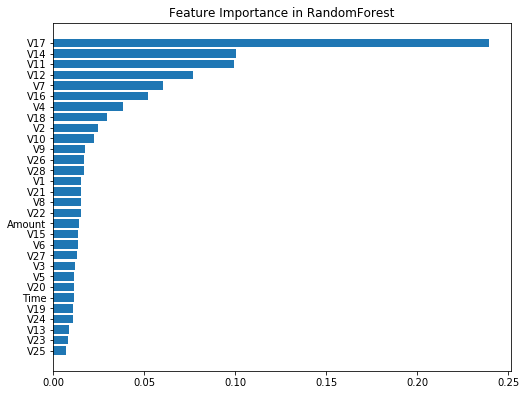

In [160]:
plt.figure(figsize=[8.2, 6.4])
plt.title(r"Feature Importance in RandomForest")
plt.barh([x+1 for x in range(30)], width=val, tick_label=label)

### 训练AdaBoost模型

In [161]:
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=0)
abc_fit = abc.fit(X_train,y_train)

In [162]:
yhat_abc = abc_fit.predict(X_test)
yhat_abc_proba = abc_fit.predict_proba(X_test)
yhat_abc_proba = [x[1] for x in yhat_abc_proba]
fpr, tpr, thresholds = roc_curve(y_test, yhat_abc_proba)
ada_score = roc_auc_score(y_test, yhat_abc_proba)
ada_score

0.9802154553895501

AdaBoost的模型AUC达到惊人的0.9802! 这是在test集上的表现，在全集上的AUC为0.9948.远远优于随机森林。

In [163]:
yhat_abc_probaX = abc_fit.predict_proba(X)
yhat_abc_probaX = [x[1] for x in yhat_abc_probaX]
ada_scoreX = roc_auc_score(y, yhat_abc_probaX)
ada_scoreX

0.9947952317000968

查看AdaBoost的ROC曲线

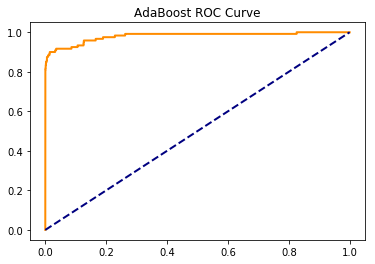

In [164]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="ROC curve")
plt.plot([0,1],[0,1], color="navy", lw=lw, linestyle="--")
plt.title(r"AdaBoost ROC Curve")
plt.show()